# Kaggle | OkCupid Profiles
## Recomendación de perfiles afines mediante aprendizaje no supervisado

----


### Contexto

OkCupid es una aplicación móvil de citas. Se diferencia del resto de aplicaciones a través de la forma de recomendar perfiles. Calcula en base a unas preguntas hechas a priori, cual es la compatibilidad que tiene los perfiles entre sí.

### Proyecto

Se pretende realizar el mecanismo de emparejamiento de los perfiles mediante el uso de algoritmos de aprendizaje no supervisado. Se quiere que el sistema sea capaz de poder recomendar a un perfil x una ranking de perfiles más afines 

### Dataset
En el dataset hay 60k registros que contienen los datos estructurados de los perfiles, indicandose la edad, el sexo, la orientación sexual y una descripción.

----

## Paquetería y dataset


In [54]:
!pip install umap-learn
!pip install mplcyberpunk

In [63]:
import os
import warnings
import re
import glob
import ntpath

from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA as PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
import umap

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE, Isomap
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN, SpectralClustering
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import NearestNeighbors

warnings.filterwarnings(action='ignore')  

In [ ]:
#!wget https://drive.upm.es/index.php/s/LkFtKeCdq9ElQZX/download -O OkCupid.zip
!unzip OkCupid.zip
!rm OkCupid.zip

## Preprocesamiento
----

In [3]:
list_essay = ['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9']
columns_no_interest = ['last']
date_format = "%Y-%m-%d-%H-%M"
today = pd.to_datetime(datetime.now(), format=date_format)

In [4]:
def plot_change(df_previous, df_now, column, line=0):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    g1 = sns.countplot(x=column, palette="Pastel2", data=df_previous, ax=ax1)
    ax1.set_title(f'Before: {len(df_previous[column].value_counts())} different values')
    g1.set(xticklabels=[])
    if line > 0:
        ax1.axvline(x=line)
        
    g2 = sns.countplot(x=column, palette="Pastel2", data=df_now, ax=ax2)
    ax2.set_title(f'After: {len(df_now[column].value_counts())} different values')
    g2.set(xticklabels=[])
    fig.tight_layout()
    plt.show()

Se carga el dataset del fichero .csv a un Dataframe de pandas

In [5]:
df = pd.read_csv('okcupid_profiles.csv')
print(df.shape)

(59946, 31)


Se unifican todas las columnas de tipo essay, a una concatenación de todas ellas:
$$essay = \sum_{i=0}^{9}essay_{i}$$

In [6]:
df['essay'] = df[df.columns[21:]].apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)
df.drop(columns=list_essay, inplace=True)
[[df[column].name, df[column].dtype, len(df[column].value_counts())] for column in df.columns]

[['age', dtype('int64'), 54],
 ['status', dtype('O'), 5],
 ['sex', dtype('O'), 2],
 ['orientation', dtype('O'), 3],
 ['body_type', dtype('O'), 12],
 ['diet', dtype('O'), 18],
 ['drinks', dtype('O'), 6],
 ['drugs', dtype('O'), 3],
 ['education', dtype('O'), 32],
 ['ethnicity', dtype('O'), 217],
 ['height', dtype('float64'), 60],
 ['income', dtype('int64'), 13],
 ['job', dtype('O'), 21],
 ['last_online', dtype('O'), 30123],
 ['location', dtype('O'), 199],
 ['offspring', dtype('O'), 15],
 ['pets', dtype('O'), 15],
 ['religion', dtype('O'), 45],
 ['sign', dtype('O'), 48],
 ['smokes', dtype('O'), 5],
 ['speaks', dtype('O'), 7647],
 ['essay', dtype('O'), 57808]]

A continuación se eliminan todas las columnas y filas que no tengan % de valores distintos de Nan

In [7]:
threshold_columns = 0.85
threshold_index = 0.80
# Drop columns
list_drop_columns = [column for column in df if df[column].count() / len(df) <= threshold_columns]
df.drop(columns=list_drop_columns, inplace=True)
# Drop index
indices = df[df.isna().sum(axis=1)>=(threshold_index*len(df.columns))].index
df.drop(index=indices, inplace=True)
print(f"Eliminamos las siguientes columnas al no tener un {threshold_columns}% de valores distintos de Nan:")
print(list_drop_columns)
print(f"Eliminamos las siguientes filas al no tener un {threshold_index}% de valores distintos de Nan")
print(len(indices))

Eliminamos las siguientes columnas al no tener un 0.85% de valores distintos de Nan:
['diet', 'drugs', 'offspring', 'pets', 'religion', 'sign']
Eliminamos las siguientes filas al no tener un 0.8% de valores distintos de Nan
0


Eliminamos las filas que no contiene el valor de altura. (Casi todos sus campos son Nan)

In [8]:
df.drop(index=df[df.height.isna()].index, inplace=True)
df = df.fillna('N/A')

Modificamos la columna education, para reducir el número de valores categóricos diferentes.

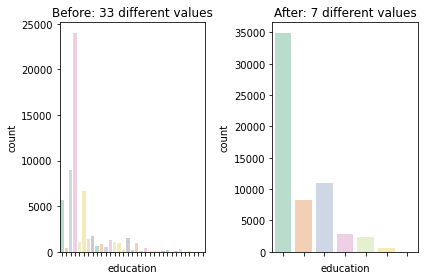

In [9]:
df_old = df.copy()
values_education = [['graduated from ph.d program', 'working on ph.d program', 'ph.d program'],
              ['graduated from masters program', 'working on masters program', 'masters program', 'dropped out of ph.d program'],
              ['graduated from college/university', 'working on college/university','graduated from two-year college','graduated from law school','working on two-year college', 'college/university', 'working on law school','two-year college', 'dropped out of masters program', 'law school'],
              ['graduated from high school', 'dropped out of college/university', 'dropped out of two-year college', 'dropped out of high school', 'high school', 'working on high school', 'dropped out of law school'],
              ['graduated from med school', 'working on med school', 'med school'],
              ['dropped out of med school'],
              ['N/A', 'graduated from space camp', 'dropped out of space camp', 'working on space camp', 'space camp']]
new_types = ['Phd', 'Master', 'College', 'High School', 'Med School', 'None', 'Other']
old_values = []
new_values = []
for counter, values in enumerate(values_education):
    new_education = new_types[counter]
    for val in values:
        old_values.append(val)
        new_values.append(new_education)
df['education'] = df['education'].replace(old_values, new_values)

plot_change(df_old, df, 'education', line=0)

Modificamos la columna ethnicity, agrupando las categorias con una menor representación como other.

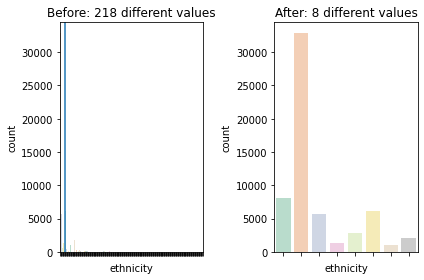

In [10]:
df_old = df.copy()
df['ethnicity'] = df['ethnicity'].replace(df.ethnicity.value_counts()[8:].index, value='other')
plot_change(df_old, df, 'ethnicity', line=8)

Modificamos el campo last_online, convirtiéndolo en un valor entero que contenga los dias desde su última conexión

In [11]:
df["last_online"] = pd.to_datetime(df["last_online"], format=date_format)
df["last_online"] = (today-df["last_online"]).dt.days

Separamos el campo location por comas, obteniendo el estado y la ciudad. Comprobando la distribución de los datos, mayoria de estados y ciudades es el mismo, por lo que se eliminan ambas columnas.

In [12]:
series_city_state = df.location.str.split(",", n=2, expand=True)
df['City'] = series_city_state[0]

Se descompone la columna speaks, en columnas separadas por ',' eliminando el contenido de los paréntesis. 
- Primera columna resultante, único valor = english. Se dropea la columna
- Nos quedamos con la segunda columna que es la que contiene más valores no nan, denominándola foreign_language
- Reducimos el número de categorias de foreign_language a las más representativas, unificando el resto en other

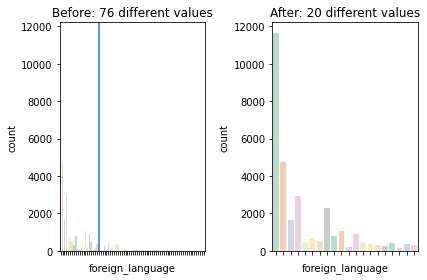

In [13]:
series_speaks = df.speaks.str.split(",", expand=True)
for column in series_speaks.columns:
    series_speaks[column] = series_speaks[column].str.replace(r"\(.*\)","")
df['foreign_language'] = series_speaks[1].str.strip()
df_old = df.copy()
df['foreign_language'] = df['foreign_language'].replace(df.foreign_language.value_counts()[20:].index, value='other')
plot_change(df_old, df, 'foreign_language', line=20)

In [14]:
df.drop(columns=['location'], inplace=True)
df.drop(columns=['City'], inplace=True)
df.drop(columns=['speaks'], inplace=True)

Resumen final valores únicos y tipo de cada columna del dataset.

In [15]:
[[df[column].name, df[column].dtype, len(df[column].value_counts())] for column in df.columns]

[['age', dtype('int64'), 54],
 ['status', dtype('O'), 5],
 ['sex', dtype('O'), 2],
 ['orientation', dtype('O'), 3],
 ['body_type', dtype('O'), 13],
 ['drinks', dtype('O'), 7],
 ['education', dtype('O'), 7],
 ['ethnicity', dtype('O'), 8],
 ['height', dtype('float64'), 60],
 ['income', dtype('int64'), 13],
 ['job', dtype('O'), 22],
 ['last_online', dtype('int64'), 371],
 ['smokes', dtype('O'), 6],
 ['essay', dtype('O'), 57806],
 ['foreign_language', dtype('O'), 20]]

Se guardan 3 datasets como .csv:
- dataset_clean: corresponde al dataset con el preprocesado.
- dataset_to_cluster: corresponde al dataset añadiendo los one-hot encoders de las variables categóricas, eliminado la columna essay.
- dataset_of_essays: corresponde a la columna de essay.

In [16]:
df.to_csv(r'./dataset_clean.csv', index = False)
print(df.shape)

(59943, 15)


In [17]:
dummies_status = pd.get_dummies(df.status, prefix='status')
dummies_sex = pd.get_dummies(df.sex, prefix='sex')
dummies_orientation = pd.get_dummies(df.orientation, prefix='orientation')
dummies_body_type = pd.get_dummies(df['body_type'], prefix='body_type')
dummies_drinks = pd.get_dummies(df['body_type'], prefix='body_type')
dummies_education = pd.get_dummies(df['education'], prefix='education')
dummies_ethnicity = pd.get_dummies(df['ethnicity'], prefix='ethnicity')
dummies_job = pd.get_dummies(df['job'], prefix='job')
dummies_smokes = pd.get_dummies(df['smokes'], prefix='smokes')
dummies_foreign_language = pd.get_dummies(df['foreign_language'], prefix='foreign_language')

df = pd.concat([df, dummies_status, dummies_sex, dummies_orientation, dummies_body_type,
               dummies_drinks, dummies_education, dummies_ethnicity, dummies_job, 
               dummies_smokes, dummies_foreign_language], axis=1)
df_essay = df['essay']

df.drop(columns=df.select_dtypes(include='object').columns, inplace=True)

In [18]:
df.to_csv(r'./dataset_to_cluster.csv', index = False)
df_essay.to_csv(r'./dataset_of_essays.csv', index = False)
print(df.shape)
print(df_essay.shape)

(59943, 103)
(59943,)


In [19]:
df = pd.read_csv(r'./dataset_to_cluster.csv')
df_essay = pd.read_csv(r'./dataset_of_essays.csv')
df_clean = pd.read_csv(r'./dataset_clean.csv')

## Clusterización

Se pasará a evaluar los siguientes métodos de clusterización:
- KMeans
- DBScan
- Spectral Clustering.
----


Aplicamos normalizacion a nuestro dataset

In [21]:
X = MinMaxScaler().fit_transform(df)

### KMeans

Utilizamos el coeficiente de Silhouette como medida de calidad

For n_clusters = 2 The average silhouette_score is : 0.09469543901764615
For n_clusters = 3 The average silhouette_score is : 0.09949706925218527
For n_clusters = 4 The average silhouette_score is : 0.13082356731062347
For n_clusters = 5 The average silhouette_score is : 0.13859108044413138
For n_clusters = 6 The average silhouette_score is : 0.11530827487269528
For n_clusters = 7 The average silhouette_score is : 0.1597073760047438
For n_clusters = 8 The average silhouette_score is : 0.14096763369943946
For n_clusters = 9 The average silhouette_score is : 0.11909447036774497
For n_clusters = 10 The average silhouette_score is : 0.10692164254865927


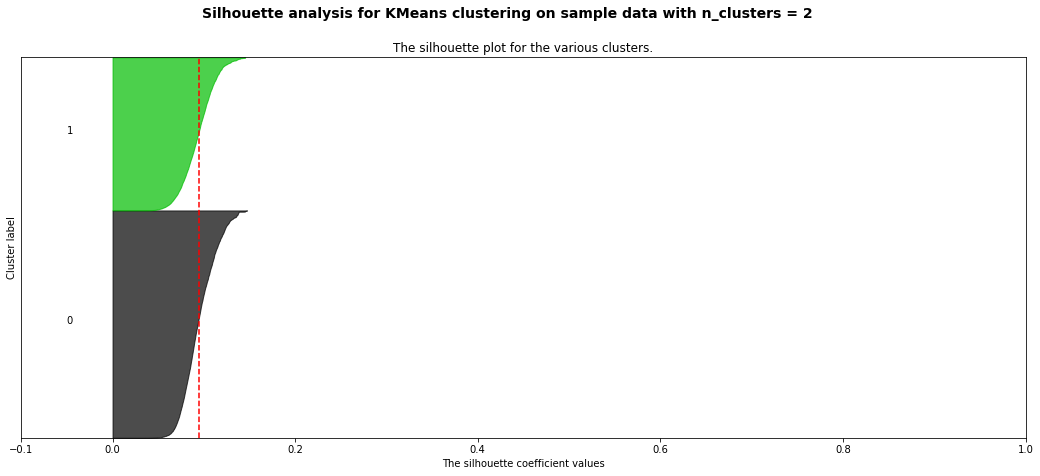

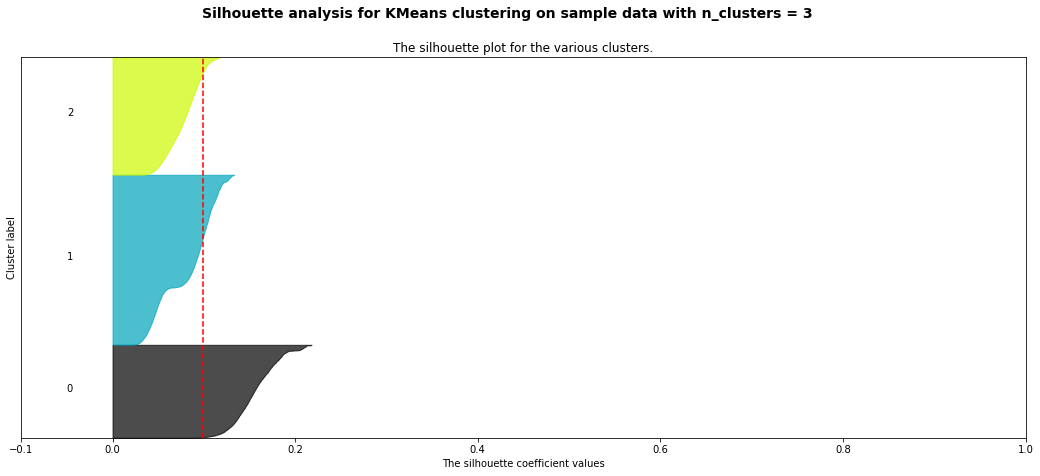

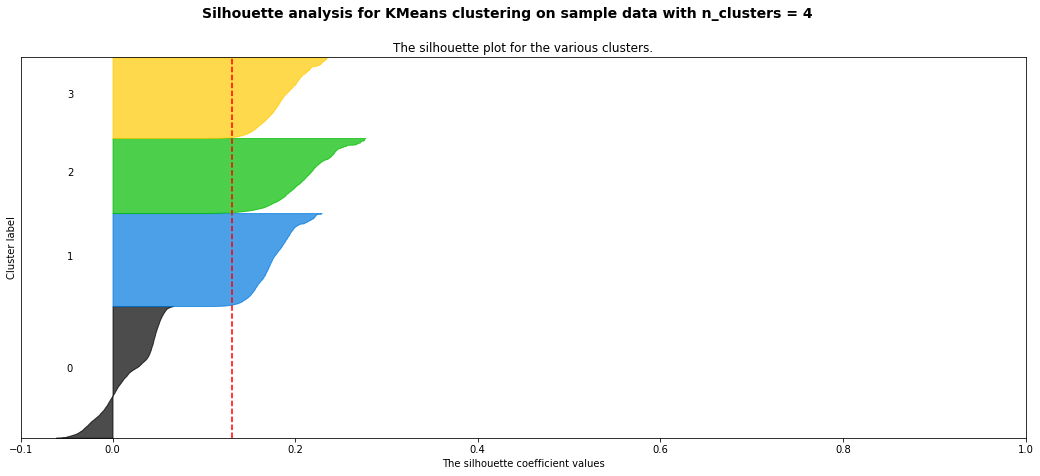

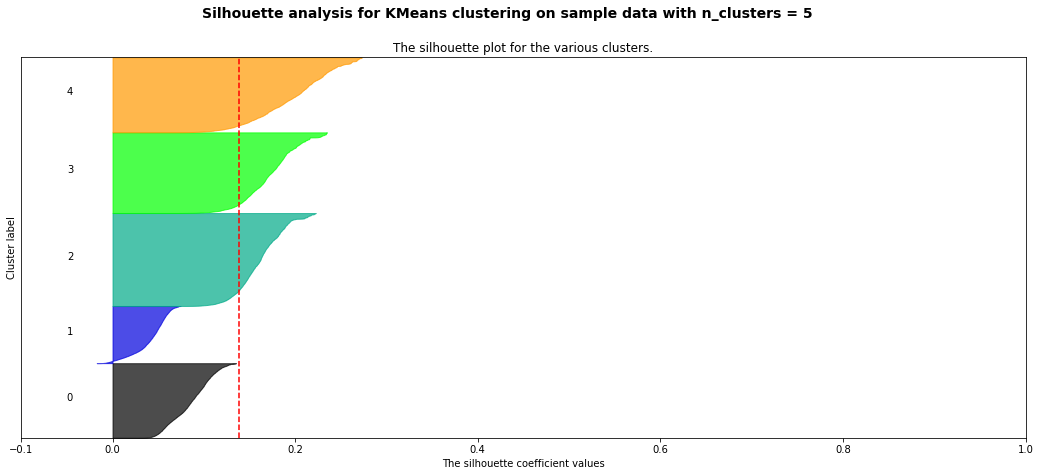

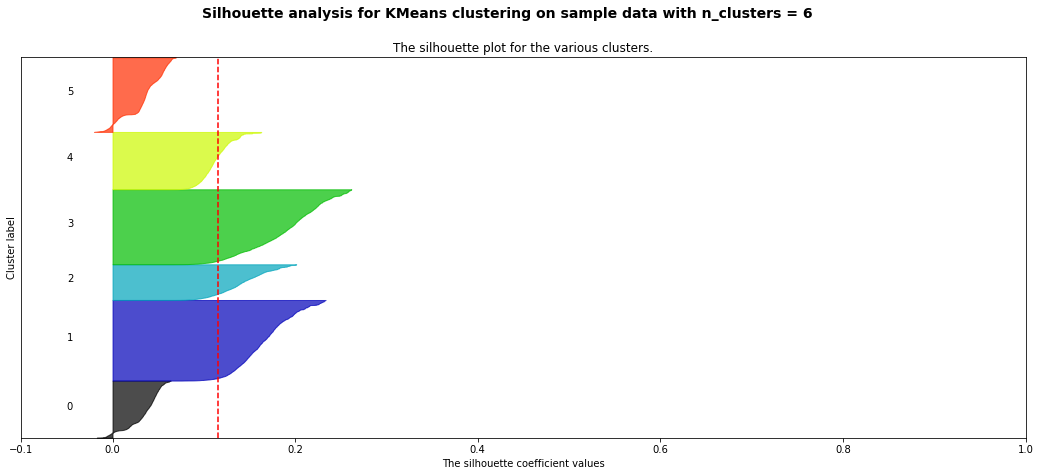

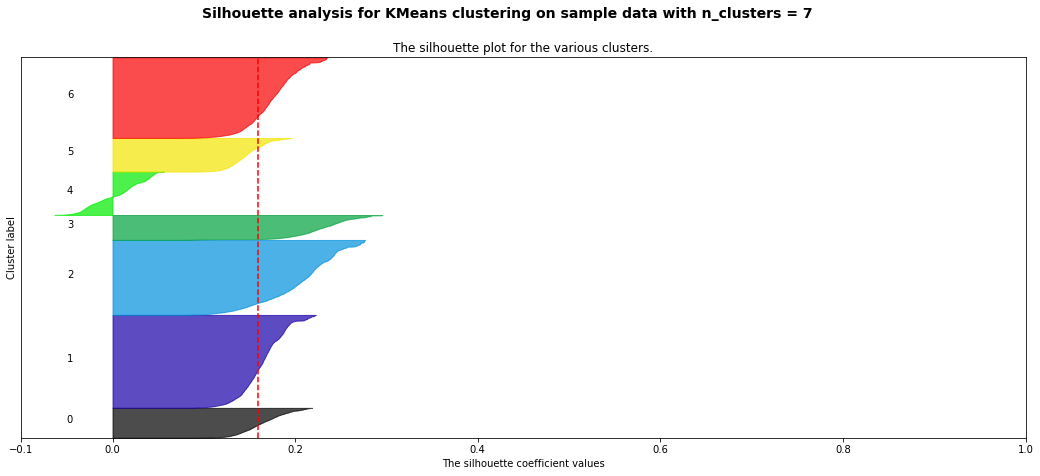

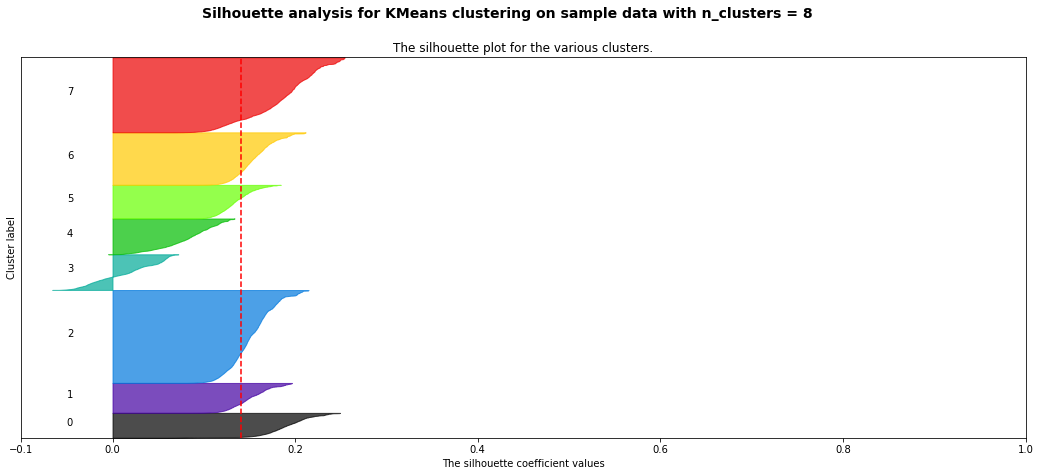

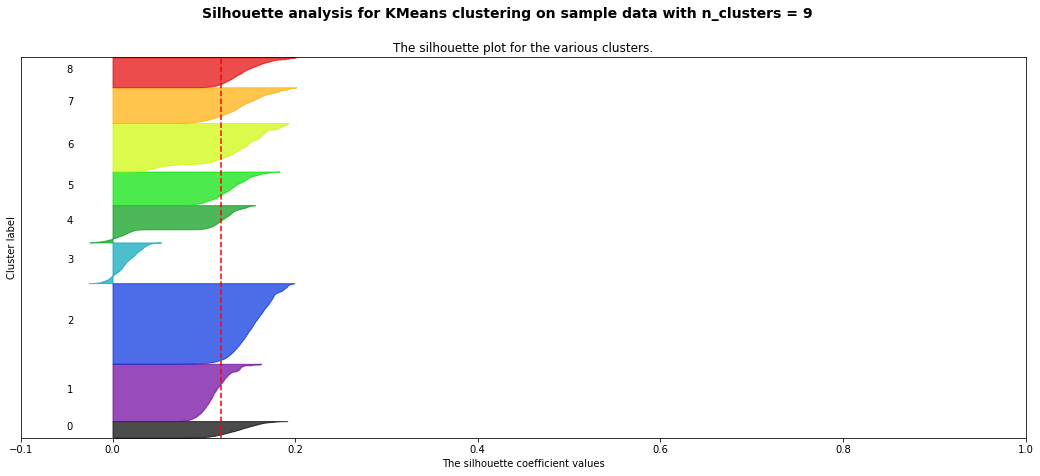

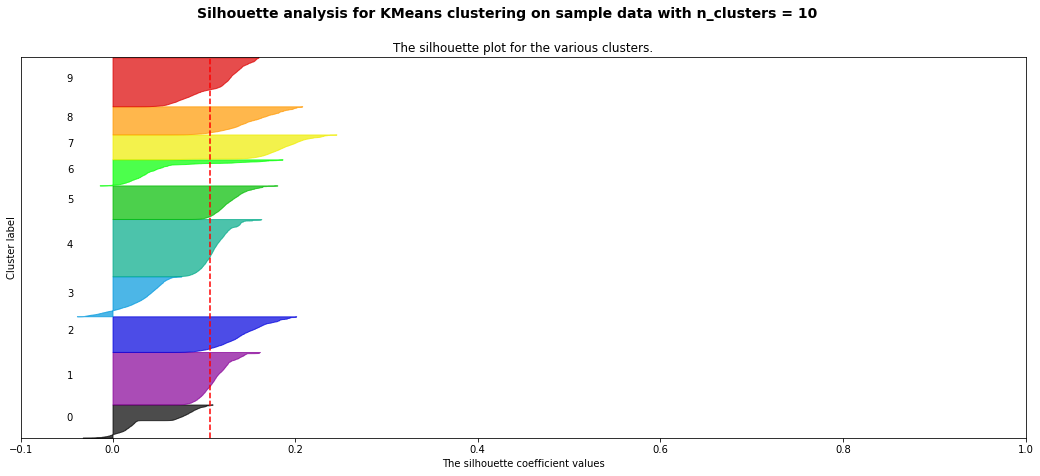

In [22]:
range_n_clusters = range(2,11,1)

for n_clusters in range_n_clusters:

    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)

        ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle((f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}"),
    fontsize=14, fontweight='bold')

plt.show()

El numero de clusters con mejor coeficiente de silhouette es: n_clusters = 7

### DBSCAN

Determinamos valores óptimos (locales) para los hiper-parámetros del algoritmo:

1. Calculamos las distancias desde cada punto a los $minPoints-1$ más cercanos
2. Ordenamos las distancias, visualizamos y eligimos el $\varepsilon$ donde la curva es más pronunciada

**Nota**: El numero minimo de puntos a la hora de hacer NN se correspondera con las columnas del dataset

In [23]:
minPts = X.shape[1]
neighbors = NearestNeighbors(n_neighbors = minPts, n_jobs=-1)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

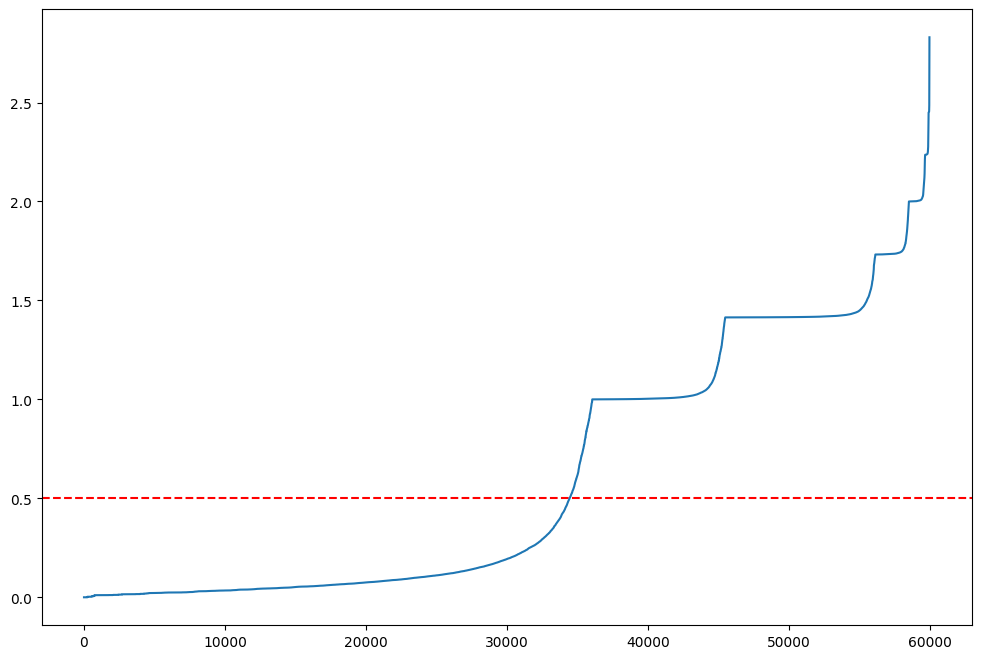

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.axhline(y=0.5, linestyle='--',c='red')
ax.plot(distances)

$\varepsilon$ = 0.5

In [51]:
clusterer = DBSCAN(eps=0.5, min_samples=minPts, n_jobs=-1)
cluster_labels = clusterer.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print("The average silhouette_score is :", silhouette_avg)

sample_silhouette_values = silhouette_samples(X, cluster_labels)

The average silhouette_score is : -0.2372707766690049


Un valor cercano a cero significa que existe solapamiento entre clusters

In [52]:
n_clusters = np.unique(cluster_labels).size

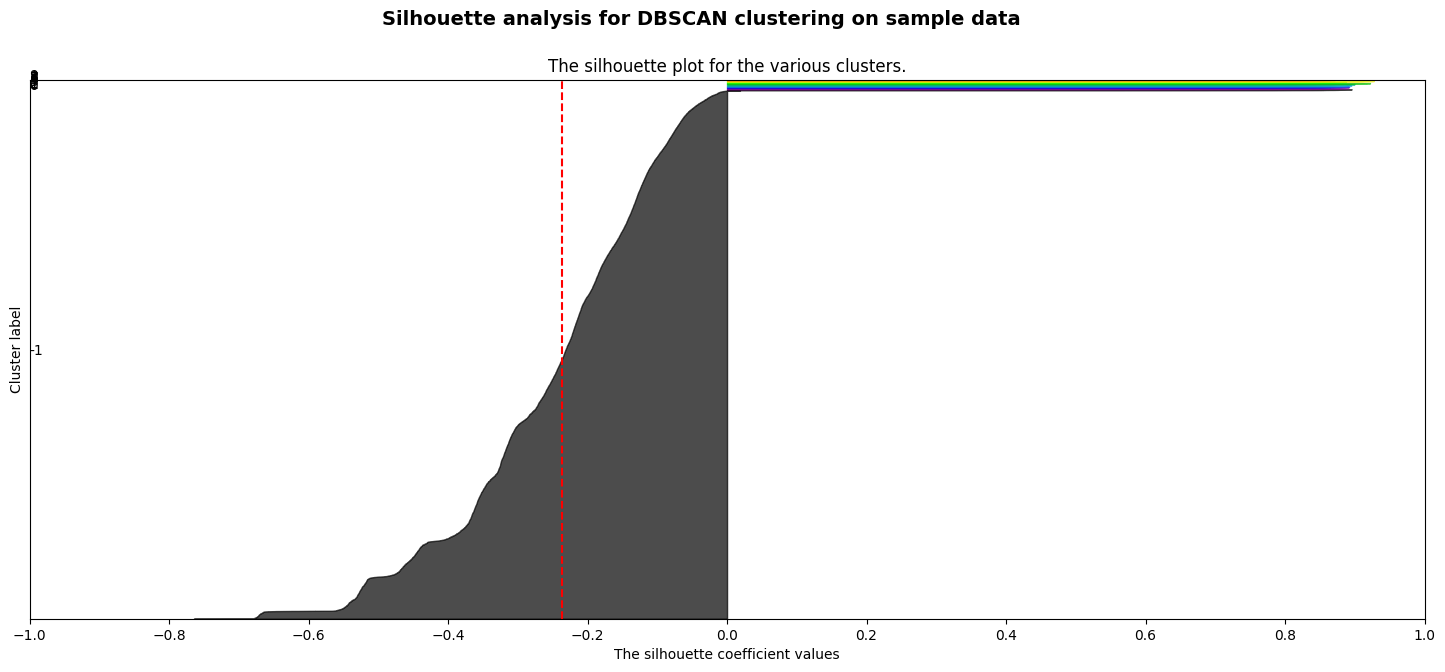

In [53]:
plt.style.use('default')
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 7)
ax1.set_xlim([-1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

y_lower = 0

for i in range(-1,n_clusters):

    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-1, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10 # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])

plt.suptitle((f"Silhouette analysis for DBSCAN clustering on sample data "),fontsize=14, fontweight='bold')

plt.show()

### Spectral Clustering

Debido a su gran consumo de memoria, no realizamos este modelo de clusterizacion. Sin embargo, mostramos el codigo de como se realizaria en caso de tener la suficiente memoria para ejecutarlo.

In [ ]:
range_n_clusters = range(2,11,1)

for n_clusters in range_n_clusters:

    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = SpectralClustering(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle((f"Silhouette analysis for Spectral clustering on sample data with n_clusters = {n_clusters}"),
    fontsize=14, fontweight='bold')

plt.show()

# Selección de clustering
Tras las pruebas realizas entre KMeans, DBSCAN y Spectral Clustering:

- Seleccionamos KMeans k=7

In [55]:
import mplcyberpunk

In [56]:
def print_groups(labels, X, index):
    plt.style.use("cyberpunk")
    X_proyection = Isomap(n_neighbors=10, n_jobs=-1).fit_transform(X[index])
    labels_names = ['Cluster '+str(n) for n in np.unique(labels)]
    plt.figure(figsize=(12, 8), dpi=80)
    scatter = plt.scatter(X_proyection[:,0], X_proyection[:,1], c=labels[index], cmap='rainbow')
    plt.legend(handles=scatter.legend_elements()[0], labels=labels_names, title="Group")

    plt.show()

In [57]:
clf_KMeans = KMeans(n_clusters=7, random_state=10).fit(X)
cluster_labels = clf_KMeans.predict(X)

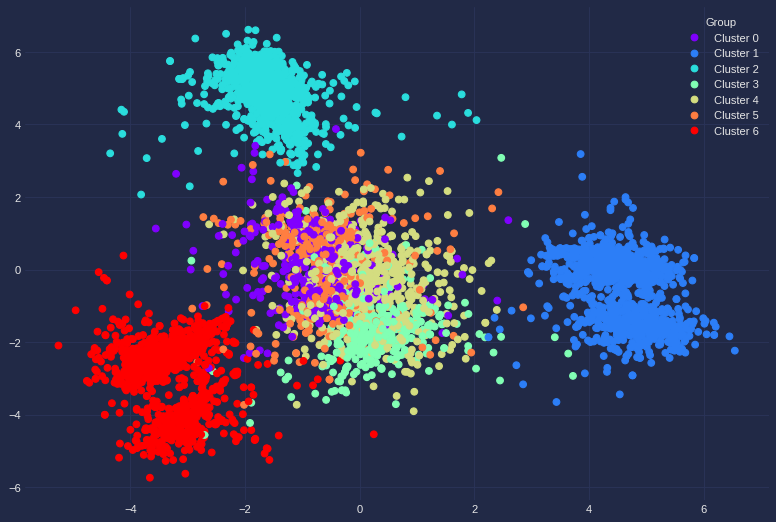

In [58]:
index = np.random.randint(0, X.shape[0], size=6000)
print_groups(cluster_labels, X, index)

In [59]:
# Diferentes visualizaciones de los clusters: PCA, ISOMAP, TSNE Y UMAP.

index = np.random.randint(0, X.shape[0], size=6000)

X_vis = X[index]
Y = cluster_labels[index]

pca_model = PCA(n_components=2).fit_transform(X_vis)
isomap_models = [Isomap(n_neighbors=n_nei, n_components=2, metric='euclidean', n_jobs = -1).fit_transform(X_vis) 
                for n_nei in [10,20,35,50]]
tsne_models = [TSNE(n_components=2, perplexity=per, n_iter = 5000, metric='euclidean', n_jobs = -1).fit_transform(X_vis) 
               for per in [10,20,35,50]]
umap_models = [umap.UMAP(n_components = n_nei, n_neighbors = n_nei, min_dist = min_dist, metric='euclidean', n_jobs = -1)
               .fit_transform(X_vis) for n_nei in [10,20,35,50] for min_dist in [0.1,0.25,0.5,0.8]]

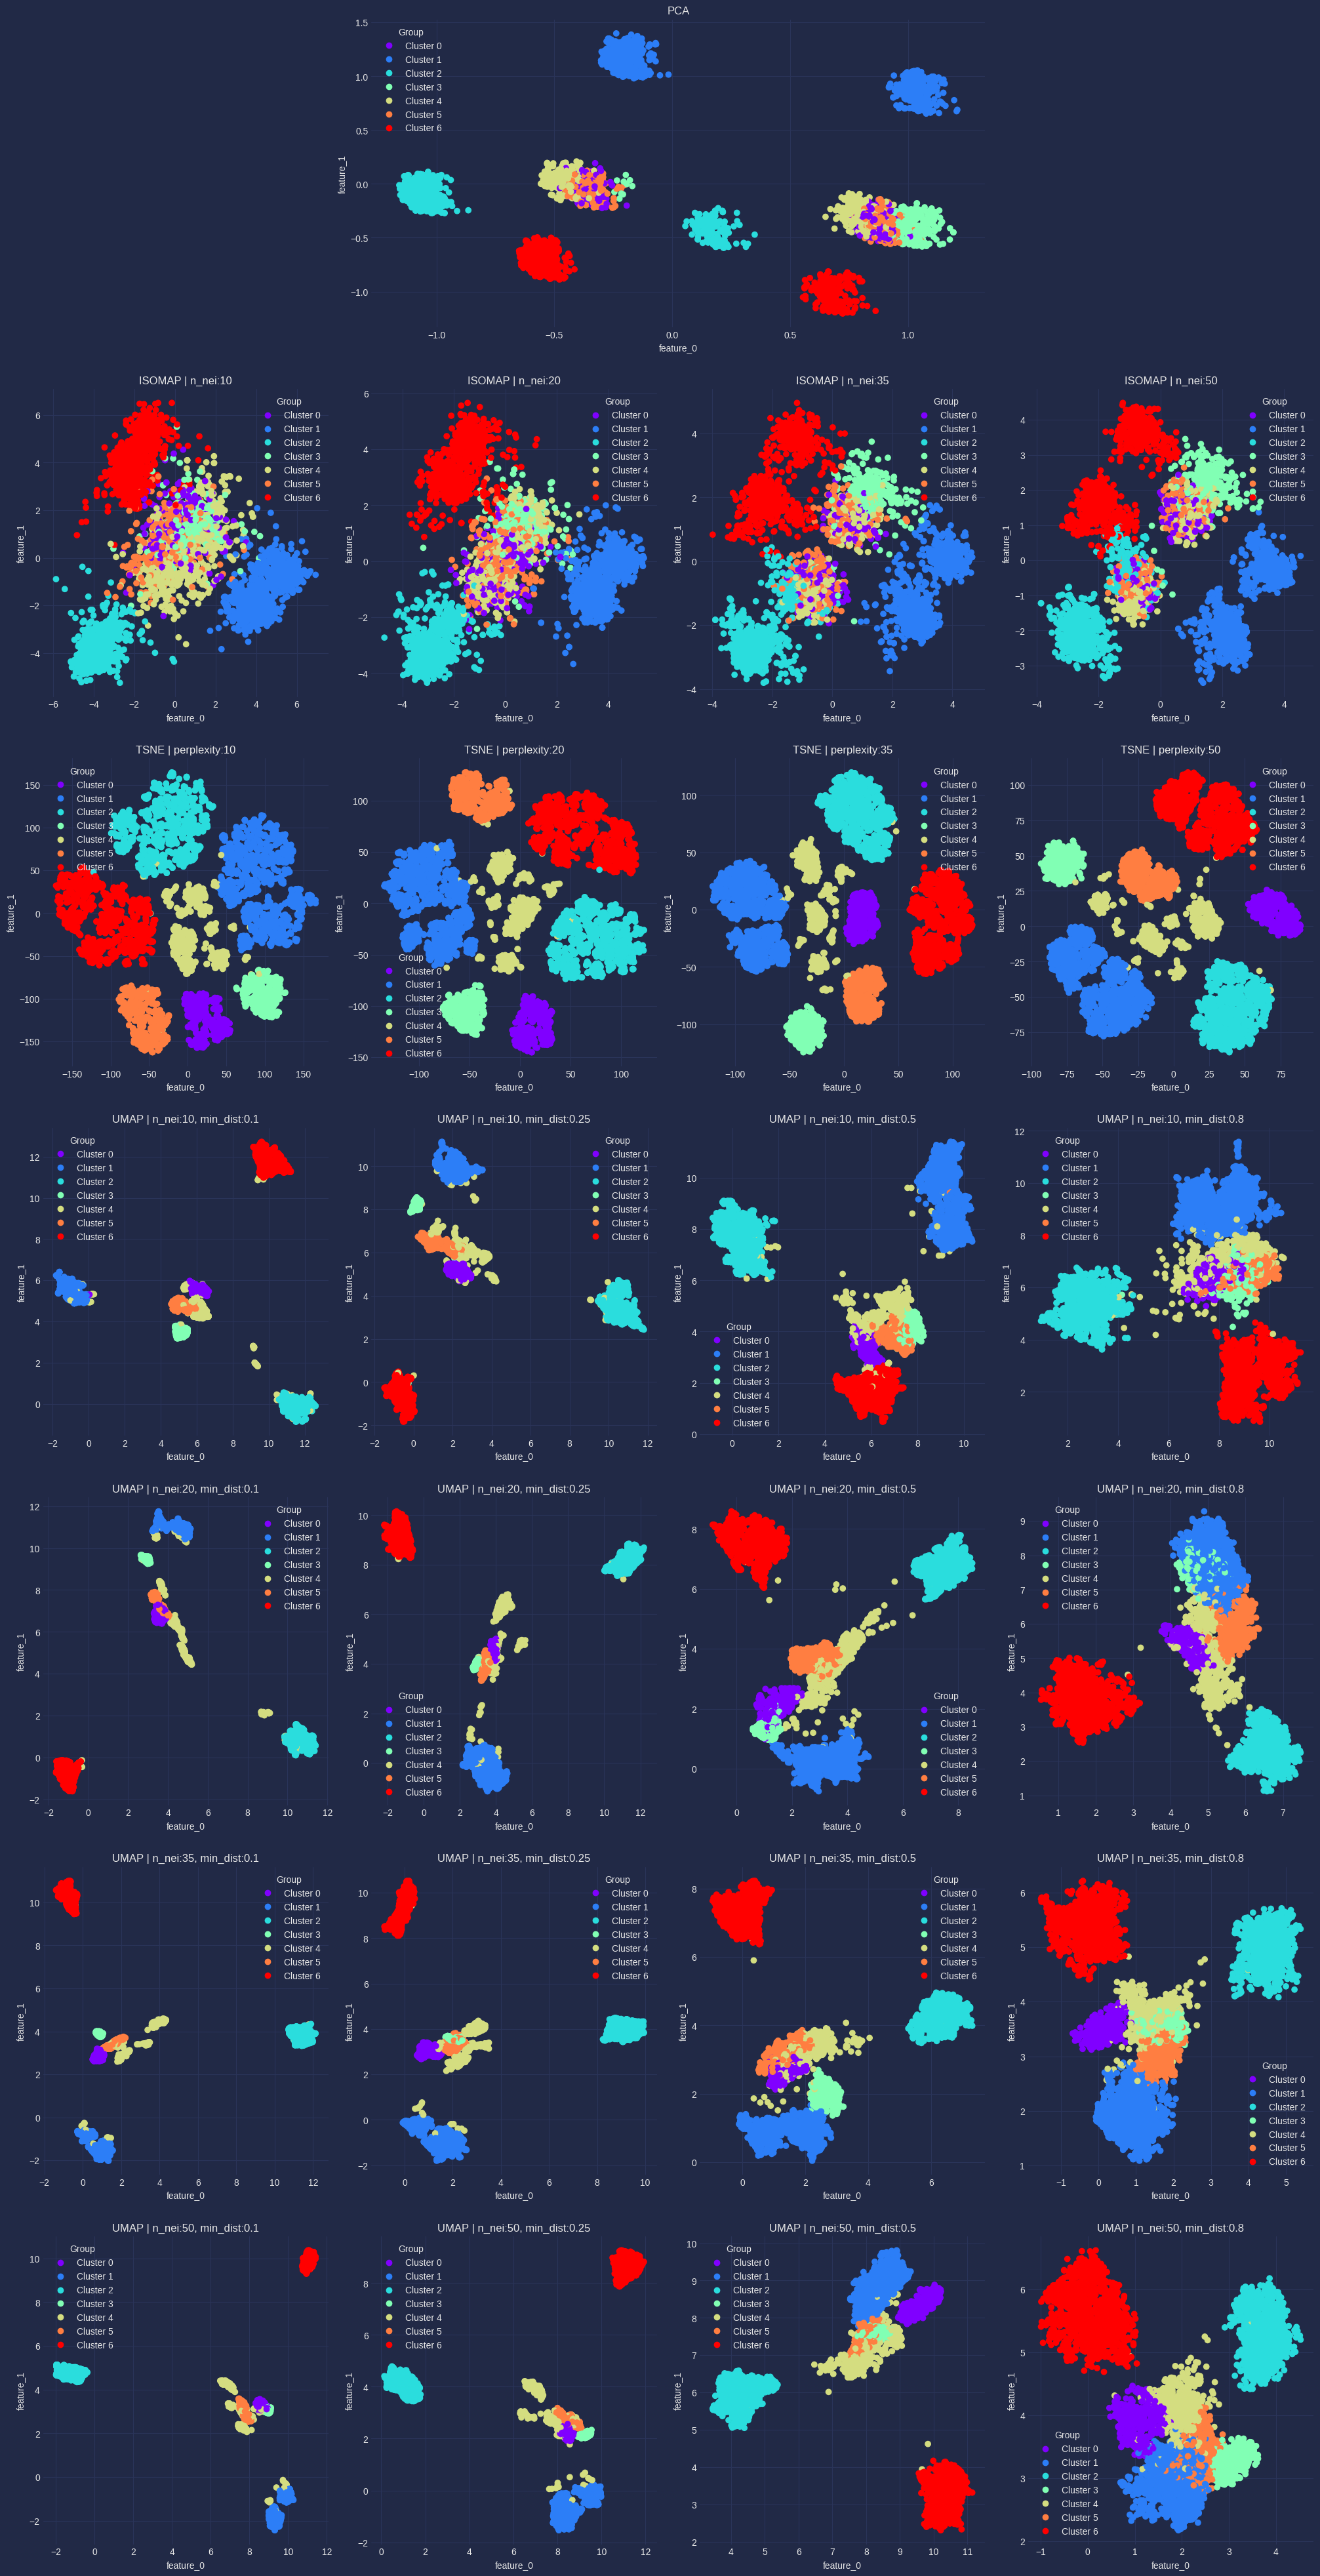

In [60]:
# Plot de los diferentes reductores dimensionales

labels_names = ['Cluster '+str(n) for n in np.unique(Y)]

plt.style.use('cyberpunk')

fig = plt.figure(figsize = (25,50))
fig.tight_layout(pad=2.0)

grid = plt.GridSpec(7, 4, hspace=0.2, wspace=0.15)

pca_plot = fig.add_subplot(grid[0, 1:3])
isomap_plots = [fig.add_subplot(grid[1, i:i+1]) for i in range(4)]
tsne_plots = [fig.add_subplot(grid[2, i:i+1]) for i in range(4)]
umap_plots = [fig.add_subplot(grid[i+3, j:j+1]) for i in range(4) for j in range(4)]

scatter = pca_plot.scatter(pca_model[:,0], pca_model[:,1], c = Y, cmap = 'rainbow')
pca_plot.set_title('PCA')
pca_plot.set_xlabel('feature_0')
pca_plot.set_ylabel('feature_1')
pca_plot.legend(handles=scatter.legend_elements()[0], labels=labels_names, title="Group")

param_isomap = [n_nei for n_nei in [10,20,35,50]]

for index, model in enumerate(isomap_models):
    scatter = isomap_plots[index].scatter(model[:,0], model[:,1], c = Y, cmap = 'rainbow')
    isomap_plots[index].set_title(f'ISOMAP | n_nei:{param_isomap[index]}')
    isomap_plots[index].set_xlabel('feature_0')
    isomap_plots[index].set_ylabel('feature_1')
    isomap_plots[index].legend(handles=scatter.legend_elements()[0], labels=labels_names, title="Group")
    
param_tsne = [per for per in [10,20,35,50]]
    
for index, model in enumerate(tsne_models):
    scatter = tsne_plots[index].scatter(model[:,0], model[:,1], c = Y, cmap = 'rainbow')
    tsne_plots[index].set_title(f'TSNE | perplexity:{param_tsne[index]}')
    tsne_plots[index].set_xlabel('feature_0')
    tsne_plots[index].set_ylabel('feature_1')
    tsne_plots[index].legend(handles=scatter.legend_elements()[0], labels=labels_names, title="Group")
    
param_umap = [(n_nei,min_dist) for n_nei in [10,20,35,50] for min_dist in [0.1,0.25,0.5,0.8]]

for index, obj in enumerate(zip(umap_plots,umap_models)):
    scatter = obj[0].scatter(obj[1][:,0], obj[1][:,1], c = Y, cmap = 'rainbow')
    obj[0].set_title(f'UMAP | n_nei:{param_umap[index][0]}, min_dist:{param_umap[index][1]}')
    obj[0].set_xlabel('feature_0')
    obj[0].set_ylabel('feature_1')
    obj[0].legend(handles=scatter.legend_elements()[0], labels=labels_names, title="Group")

plt.show()

In [61]:
df_clean['Group'] = cluster_labels

In [62]:
df_clean

,age,status,sex,orientation,body_type,drinks,education,ethnicity,height,income,job,last_online,smokes,essay,foreign_language,Group
0,22,single,m,straight,a little extra,socially,College,other,75.0,-1,transportation,3436,sometimes,about me: i would love to think that i was so...,NaN,4
1,35,single,m,straight,average,often,Other,white,70.0,80000,hospitality / travel,3435,no,i am a chef: this is what that means. 1. i am ...,spanish,1
2,38,available,m,straight,thin,socially,Master,NaN,68.0,-1,NaN,3438,no,"i'm not ashamed of much, but writing public te...",french,0
3,23,single,m,straight,thin,socially,College,white,71.0,20000,student,3437,no,"i work in a library and go to school. . .,read...",german,0
4,29,single,m,straight,athletic,socially,College,other,66.0,-1,artistic / musical / writer,3437,no,hey how's it going? currently vague on the pro...,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59938,59,single,f,straight,NaN,socially,College,NaN,62.0,-1,sales / marketing / biz dev,3452,no,"vibrant, expressive, caring optimist. i love b...",NaN,5
59939,24,single,m,straight,fit,often,College,other,72.0,-1,entertainment / media,3436,no,i'm nick. i never know what to write about mys...,NaN,6
59940,42,single,m,straight,average,not at all,Master,asian,71.0,100000,construction / craftsmanship,3437,no,"hello! i enjoy traveling, watching movies, and...",NaN,1
59941,27,single,m,straight,athletic,socially,College,other,73.0,-1,medicine / health,3442,trying to quit,"""all i have in this world are my balls and my ...",spanish,2


## NLP. 
Realizamos el ranking de los essay para una persona determinada, comparando su similaridad entre ellos

In [64]:
def prep_text(essay_text):
    corpus = []
    for i in range(0, len(essay_text)):
        review = re.sub(r'\W', ' ', str(essay_text[i]))
        review = review.lower()
        review = re.sub(r'^br$', ' ', review)
        review = re.sub(r'\s+br\s+',' ',review)
        review = re.sub(r'\s+[a-z]\s+', ' ',review)
        review = re.sub(r'^b\s+', '', review)
        review = re.sub(r'\s+', ' ', review)               
        corpus.append(review)
    return corpus

def create_tfidf(corpus):
    vect = TfidfVectorizer(min_df=1, stop_words="english")
    return vect.fit_transform(corpus)   
    
def text_similarity(tfidf, idx, n=10):
    solution = tfidf[idx] * tfidf.T 
    solution = solution.toarray().flatten()
    return solution.argsort()[::-1][:n+1][1:]

In [65]:
def potential_partner(idx,n=10):
    grupo = df_clean.iloc[idx].Group
    sex = df_clean.iloc[idx].sex
    orientation = df_clean.iloc[idx].orientation

    if orientation == 'straight':
        pool = df_clean[(df_clean.Group == grupo) & (df_clean.sex != sex)]
    elif orientation == 'gay':
        pool = df_clean[(df_clean.Group == grupo) & (df_clean.sex == sex)]
    else:
        pool = df_clean[df_clean.Group == grupo]

    pool = pool.reset_index(drop=True)

    corpus = prep_text(pool.essay)
    tfidf_vector = create_tfidf(corpus)
    top_ten_index = text_similarity(tfidf_vector,idx,n)

    return pool.iloc[top_ten_index]

In [66]:
potential_partner(4)

,age,status,sex,orientation,body_type,drinks,education,ethnicity,height,income,job,last_online,smokes,essay,foreign_language,Group
2085,37,single,f,straight,athletic,rarely,Master,white,68.0,-1,other,3466,no,i've lived in sf for 4 years now after living ...,spanish,2
162,41,single,f,straight,athletic,socially,College,white,66.0,-1,executive / management,3444,no,i grew up in san francisco and i still love li...,spanish,2
394,36,single,f,straight,athletic,socially,Other,white,66.0,-1,NaN,3442,sometimes,"i love living in san francisco, practicing yog...",NaN,2
1468,48,single,f,straight,athletic,socially,Other,hispanic / latin,62.0,-1,other,3435,no,"i'm an outgoing happy woman, i love taking car...",spanish,2
1487,39,single,f,straight,athletic,socially,College,white,68.0,-1,artistic / musical / writer,3456,no,i live in mill valley and work in san francisc...,NaN,2
119,32,single,f,straight,athletic,socially,Master,white,70.0,-1,other,3443,no,like most people i've come across on this site...,german,2
1917,25,single,f,straight,athletic,socially,College,white,66.0,-1,sales / marketing / biz dev,3436,no,i live in sf and just got a great new job down...,NaN,2
186,35,single,f,straight,athletic,socially,High School,hispanic / latin,67.0,-1,other,3465,sometimes,"i am social girl, i like friendship and i beli...",spanish,2
132,26,single,f,straight,athletic,socially,College,white,64.0,-1,NaN,3443,no,"hello everyone, i am originally from russia,fo...",russian,2
2103,27,single,f,straight,athletic,socially,College,white,63.0,40000,political / government,3764,no,"i am kathleen 25 years old, moved to the bay a...",sign language,2
